# This notebook creates a model with pure stats, no feature transformations

This means we will use stats like 1B, 2B, 3B, HR, SB etc instead of transforming them to batting average or slugging percentage.

In [2]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_formats = ['svg']
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [36]:


%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [62]:
# create lists of different stats we want 
offensive_pure = ['W', 'G', 'PA', '1B', '2B', '3B', 'HR','BB', 'SB', 'SO']
offensive_against_pure = ['PA_A', '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']
offensive_features = ['PA', '1B', '2B', '3B', 'HR','BB', 'SB', 'SO']
combined_features = ['PA', '1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 
                     'PA_A', '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

combined_features_nopa = ['1B', '2B', '3B', 'HR','BB', 'SB', 'SO', 
                     '1B_A', '2B_A', '3B_A', 'HR_A','BB_A', 'SB_A', 'SO_A']

In [6]:
# create a df of pure stats
offense_df = pd.read_pickle("full_baseball_from_1950_df.pkl")
offense_df["1B"] = offense_df["H"] - offense_df["2B"] - offense_df["3B"] - offense_df["HR"]
pure_offense_df = offense_df[["Year", "Team"]+offensive_pure]

In [8]:
# create a df of pure stats for opponents
opponent_df = pd.read_pickle("opponents_from_1950_df.pkl")
opponent_df["1B"] = opponent_df["H"] - opponent_df["2B"] - opponent_df["3B"] - opponent_df["HR"]
opponent_df.rename(columns={'PA': 'PA_A', '1B':'1B_A', '2B': '2B_A', '3B':'3B_A', 'HR': 'HR_A', 'BB':'BB_A', 'SB': 'SB_A', 'SO': 'SO_A'}, inplace=True)
pure_opponent_df = opponent_df[["Year", "Team"]+offensive_against_pure]

In [9]:
full_pure_df = pd.merge(pure_baseball_df, pure_opponent_df, on=["Year", "Team"])

In [50]:
# make opponent stats per game
pure_per_game = full_pure_df[['PA_A', '1B_A', '2B_A', '3B_A', 'HR_A', 'BB_A', 'SB_A', 'SO_A']].div(full_pure_df.G, axis=0)
full_pure_df[['PA_A', '1B_A', '2B_A', '3B_A', 'HR_A', 'BB_A', 'SB_A', 'SO_A']] = pure_per_game

In [51]:
# grab all the seasons that have 162 games
all_games = full_pure_df[full_pure_df['G']==162]

In [52]:
all_games

,Year,Team,W,G,PA,1B,2B,3B,HR,BB,SB,SO,PA_A,1B_A,2B_A,3B_A,HR_A,BB_A,SB_A,SO_A
1,2019,ARI,85,162,39.0,5.37,1.78,0.25,1.36,3.33,0.54,8.40,0.237388,0.032846,0.011012,0.001105,0.008383,0.019662,0.001791,0.054374
2,2018,ARI,82,162,38.0,4.92,1.60,0.31,1.09,3.46,0.49,9.01,0.233920,0.032807,0.009869,0.000724,0.006630,0.019890,0.002515,0.055175
3,2017,ARI,93,162,38.4,5.13,1.94,0.24,1.36,3.57,0.64,8.99,0.231367,0.031550,0.010517,0.001296,0.006516,0.019662,0.002629,0.056470
4,2016,ARI,69,162,38.6,5.85,1.76,0.35,1.17,2.86,0.85,8.81,0.245275,0.037570,0.012841,0.001448,0.007697,0.022977,0.002401,0.050221
5,2015,ARI,79,162,38.7,6.19,1.78,0.30,0.95,3.02,0.81,8.10,0.238416,0.035056,0.012117,0.001143,0.006935,0.019052,0.002782,0.046296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,1975,WSN,75,162,38.7,6.19,1.33,0.19,0.60,3.57,0.67,5.89,0.245008,0.041190,0.008116,0.001981,0.003887,0.025339,0.002972,0.031664
1767,1973,WSN,79,162,38.6,6.22,1.17,0.14,0.77,4.29,0.48,4.80,0.238950,0.037761,0.007659,0.001372,0.004877,0.025949,0.002896,0.032998
1769,1971,WSN,71,162,37.6,6.16,1.22,0.18,0.54,3.35,0.31,4.94,0.237502,0.039361,0.008002,0.001600,0.005068,0.025072,0.003353,0.031588
1770,1970,WSN,73,162,38.6,5.57,1.30,0.22,0.84,4.07,0.40,6.00,0.241846,0.038447,0.008078,0.001943,0.006173,0.027282,0.002972,0.034827


## Lets look at the correlations

In [53]:
all_games[['W'] + combined_features].corr().loc[['W']]

,W,PA,1B,2B,3B,HR,BB,SB,SO,PA_A,1B_A,2B_A,3B_A,HR_A,BB_A,SB_A,SO_A
W,1.0,0.407831,0.166435,0.200016,0.042785,0.280561,0.378486,0.129489,-0.094236,-0.473008,-0.325709,-0.26083,-0.274204,-0.238343,-0.424712,-0.135972,0.18617


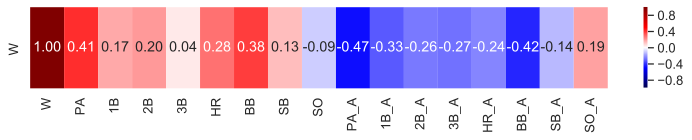

In [54]:
# plot heat map of pure stats compared to wins
f, ax = plt.subplots(figsize=(13, 1.5))
ax = sns.heatmap(all_games[['W'] + combined_features].corr().loc[['W']], cmap="seismic", annot=True, vmin=-1, vmax=1,  fmt=".2f");
# plt.gca().set_ylim(len(all_games[['W'] + combined_features].corr())+0.5, -0.5);

In [ ]:
sns.pairplot(all_games[offensive_pure]);

# Pure Least Squares Regression

In [58]:
# Create an empty model
lr = LinearRegression()

features = all_games[combined_features]


# Choose the response variable
wins = all_games['W']


# Fit the model 
lr.fit(features, wins)


# Score the model (with R^2)
lr.score(features, wins)

0.8150094156219221

So we see that using all these pure stats we get a score of .815 thats pretty good. What stats matter?

In [59]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [60]:
# Create an empty model
lr_scaled = LinearRegression()

# Fit the model 
lr_scaled.fit(scaled_features, wins)

# Score the model (with R^2)
lr_scaled.score(scaled_features, wins)

0.8150094156219221

In [61]:
for c in zip(combined_features, lr_scaled.coef_):
    print(c[0], c[1])

PA -2.907729707830609
1B 5.166644086883112
2B 3.373361829331721
3B 1.0289084614400617
HR 7.196925444420137
BB 4.194613980242313
SB 1.0678164103592331
SO -0.6038542060512018
PA_A 3.5123122279237045
1B_A -5.362252879247342
2B_A -3.8912194086438454
3B_A -1.4499496319219551
HR_A -6.161508337828407
BB_A -4.678813430567798
SB_A -0.979424573287344
SO_A 0.15966613738079993


### hmmm... Theres an inverse relationship with PA? Lets try with no opponent stats

In [64]:
# scale the data
features = all_games[offensive_features]
wins = all_games['W']
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [65]:
# Create an empty model
lr_scaled = LinearRegression()

# Fit the model 
lr_scaled.fit(scaled_features, wins)

# Score the model (with R^2)
lr_scaled.score(scaled_features, wins)

0.27776836497836743

In [66]:
for c in zip(combined_features, lr_scaled.coef_):
    print(c[0], c[1])

PA -2.1429397468397005
1B 3.1312375012200375
2B 1.1283286677511724
3B 1.1039872195646296
HR 4.877756245574601
BB 4.221396665868067
SB 1.255689181760642
SO -1.3201780655070612


### Remove PAs

In [71]:
# scale the data
features = all_games[combined_features_nopa]
wins = all_games['W']
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [72]:
# Create an empty model
lr_scaled = LinearRegression()

# Fit the model 
lr_scaled.fit(scaled_features, wins)

# Score the model (with R^2)
lr_scaled.score(scaled_features, wins)

0.8086188499940303

In [74]:
for c in zip(combined_features_nopa, lr_scaled.coef_):
    print(c[0], c[1])

1B 3.687052271639872
2B 2.5213811784850515
3B 0.8107802313049879
HR 6.392183514228074
BB 2.714509344774648
SB 1.2553820598041003
SO -0.876647724495824
1B_A -3.543587381630707
2B_A -2.89631512259121
3B_A -1.223966142627761
HR_A -5.325563586078818
BB_A -2.9546888560825715
SB_A -0.9731981817722466
SO_A 0.6319497111409058


# Validate Model with no ABs

In [108]:
# hold out 20% of the data for final testing
features = all_games[combined_features_nopa]
wins = all_games['W']
features, features_test, wins, wins_test = train_test_split(features, wins, test_size=.2, random_state=10)

In [77]:
# seperate out 25% of the training set for validation
features_train, features_val, wins_train, wins_val = train_test_split(features, wins, test_size=.25, random_state=3)

In [78]:
# create the model
lr = LinearRegression()
model = lr.fit(features_train, wins_train)

In [80]:
# check the score on the validation data... it looks good
lr.score(features_val, wins_val)

0.8164962149726426

In [85]:
# run the model on our test set... we can see we are off by an average of 4 wins, and 75% of our predictions are within 6 wins
test_wins = model.predict(features_test)
win_diff = test_wins - wins_test
win_diff.abs().describe()

count    230.000000
mean       4.038144
std        2.959940
min        0.024911
25%        1.696479
50%        3.450319
75%        5.686663
max       13.836700
Name: W, dtype: float64

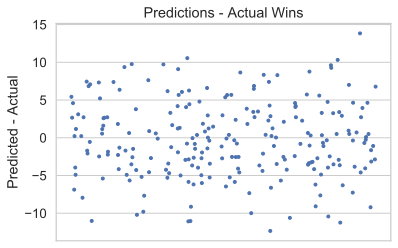

In [106]:
plt.title('Predictions - Actual Wins')
plt.xticks(ticks=[])
plt.ylabel('Predicted - Actual')
plt.plot(win_diff, '.');

In [107]:
# the win difference looks pretty well disperesed... lets plot it with respect to actual games won


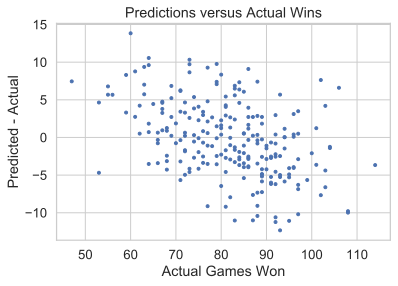

In [99]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
plt.plot(wins_test, win_diff, '.');

In [100]:
# There is a negative correlation between prediction and actual games won
# This means the more games a team won the more likely we are to under estimate their wins